In [1]:
import numpy as np
import seaborn as sns
import cv2
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pickle
import glob
from scipy import ndimage as nd
from skimage.filters import roberts, sobel, scharr, prewitt, meijering, sato, hessian
from matplotlib import pyplot as plt
#!pip install shap
#import shap

In [2]:
import sklearn
print(sklearn.__version__)

1.2.2


Import folders for original images and correspondent masks.
Make sure that mask correspond to the image when running the for loop.

In [3]:
imgs= sorted(glob.glob('/content/drive/MyDrive/random_forest/train_model/train_rgb' + '/*.jpg'))
masks= sorted(glob.glob('/content/drive/MyDrive/random_forest/train_model/train_mask'+'/*.jpg'))
print("Images #: ", len(imgs))


Images #:  15


In [4]:
dfs = pd.DataFrame()
for img, mask in zip(imgs,masks):  # [20:50]:
    df = pd.DataFrame()

    img = cv2.imread(img)

    B_0 = img[:,:,0].reshape(-1)
    df["B channel(RGB)"] = B_0

    HSV_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    H = HSV_img[:,:,0].reshape(-1)
    df["H channel(HSV)"] = H
    S = HSV_img[:,:,1].reshape(-1)
    df["S channel(HSV)"] = S
    V = HSV_img[:,:,1].reshape(-1)
    df["V channel(HSV)"] = V


    LAB_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    Bb = LAB_img[:,:,2].reshape(-1)
    df["B channel(LAB)"] = Bb

    # Use this img to extract grayscale values
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Use gray scale image to add texture features

    #ROBERTS EDGE
    edge_roberts = roberts(img)
    edge_roberts1 = edge_roberts.reshape(-1)
    df['Roberts'] = edge_roberts1

    #PREWITT
    edge_prewitt = prewitt(img)
    edge_prewitt1 = edge_prewitt.reshape(-1)
    df['Prewitt'] = edge_prewitt1

    labeled_img = cv2.imread(mask)
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_BGR2GRAY)
    labeled_img = cv2.normalize(labeled_img, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    flat_labeled_img = labeled_img.reshape(-1)

    # print(dfs)
    df["Labels"] = flat_labeled_img
    dfs = pd.concat([dfs, df], ignore_index=True)
    dfs.head()

In [5]:
dfs

,B channel(RGB),H channel(HSV),S channel(HSV),V channel(HSV),B channel(LAB),Roberts,Prewitt,Labels
0,45,11,115,115,140,0.003922,0.002773,0
1,46,11,114,114,140,0.006201,0.007452,0
2,48,11,111,111,141,0.005546,0.007622,0
3,49,11,110,110,140,0.005546,0.006201,0
4,51,10,106,106,139,0.002773,0.004134,0
...,...,...,...,...,...,...,...,...
27647995,102,10,45,45,134,0.000000,0.023274,0
27647996,102,10,45,45,134,0.003922,0.026290,0
27647997,101,10,46,46,134,0.003922,0.028669,0
27647998,102,10,45,45,134,0.003922,0.029937,0


# MODEL TRAINING

**REMEMBER**: dfs is storing the features extracted from each pixels and the response variable which is labels.

Now, divide the whole dataset in response variable y(binary digit we want to predict either 1 or 0) and the predictors x use as criteria for classification task (in this case all color channels we extracted).

In [6]:
y = dfs["Labels"].values
x = dfs.drop(labels=["Labels"], axis=1)


In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)

In [8]:
x_train.head()

,B channel(RGB),H channel(HSV),S channel(HSV),V channel(HSV),B channel(LAB),Roberts,Prewitt
15968141,17,35,135,135,140,0.039703,0.027435
23302770,174,70,9,9,129,0.000000,0.002067
23040165,182,101,63,63,116,0.003922,0.002067
15400157,46,39,108,108,147,0.022356,0.014818
24377438,120,95,36,36,125,0.182637,0.125823


In [9]:
np.unique(y_train)

array([0, 1], dtype=uint8)

In [10]:
model = RandomForestClassifier(n_estimators = 100, max_features = 7, random_state = 42,n_jobs=8)
model.fit(x_train,y_train)

RandomForestClassifier(max_features=7, n_jobs=8, random_state=42)

## RUN PREDICTION USING TEST DATA SET
Remember, it returns a binary based on pixel intensity --> Either 0 or 100

In [11]:
prediction_test = model.predict(x_test)


## TRANSFORMING 0-255 (BINARY) to boolean:
Predictions given by Random Forest model will give as an output a number from 0-255 (pixel intensity). In order to use mIoU metrics we need to have a boolean output.

Here we are storing boleans in new array named thresholded (for predictions and test)

In [12]:
prediction_test[:20]
y_test[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
      dtype=uint8)

In [21]:
from sklearn.inspection import permutation_importance

result_p = permutation_importance(
    model, x_test, y_test, n_repeats=5, random_state=42, n_jobs=8
)

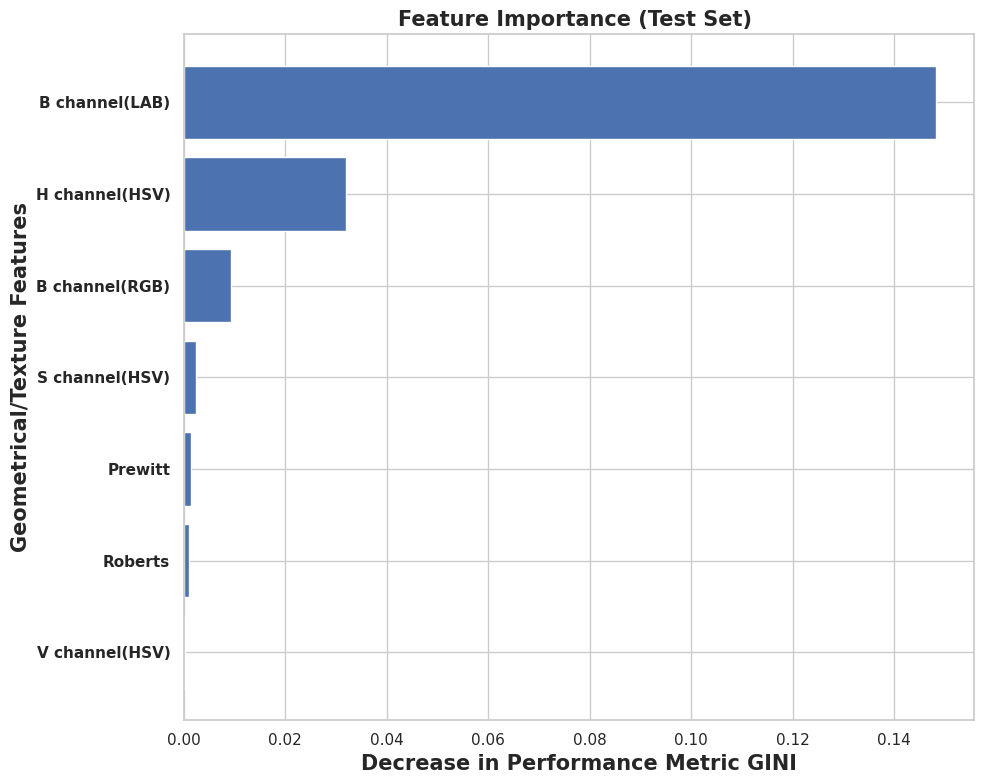

In [22]:
sorted_importances_idx = result_p.importances_mean.argsort()
importances = pd.DataFrame(
    result_p.importances[sorted_importances_idx].T,
    columns=x.columns[sorted_importances_idx],
)
''' ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance) '''
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(10,8))
plt.barh(range(len(sorted_importances_idx)), result_p.importances_mean[sorted_importances_idx], align='center')
plt.yticks(range(len(sorted_importances_idx)), np.array(list(x.columns))[sorted_importances_idx], fontsize=11, fontweight='bold')
plt.title('Feature Importance (Test Set) ',fontsize=15, fontweight='bold')
plt.xlabel("Decrease in Performance Metric GINI", size = 15,fontweight='bold')
plt.ylabel("Geometrical/Texture Features", size = 15,fontweight='bold')
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/random_forest/train_model/31-01_PERM-color-text_FINAL.png', dpi=400)

## Evaluate model performance using mIoU and metrics.accuracy score

Aditionally, I'm showing a list of the most important features in descending order from the most influential to the less influential feature.

In [20]:
feature_list = list(x.columns)
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
print(feature_imp)
feature_imp.to_csv("/content/drive/MyDrive/random_forest/train_model/30-01_Importance-Train_FINAL.csv")

B channel(LAB)    0.889725
B channel(RGB)    0.036396
H channel(HSV)    0.024689
S channel(HSV)    0.015009
V channel(HSV)    0.012653
Prewitt           0.012480
Roberts           0.009048
dtype: float64


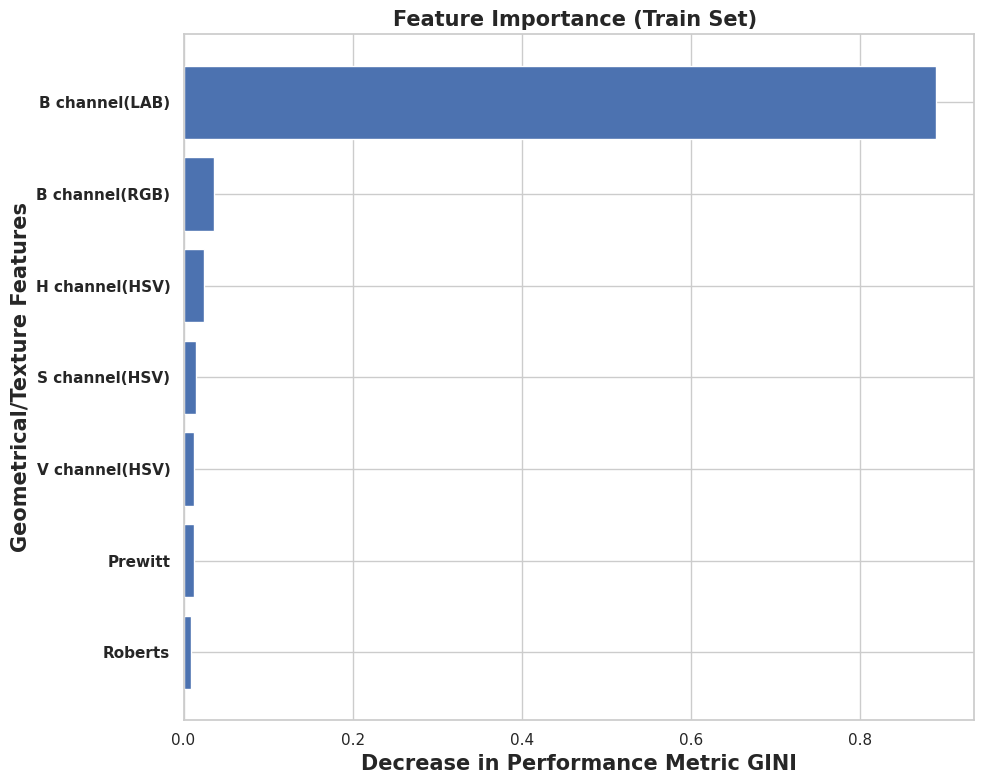

In [19]:
import seaborn as sns
sns.set_theme(style="whitegrid")
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10,8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_list)[sorted_idx], fontsize=11, fontweight='bold')
plt.title('Feature Importance (Train Set) ',fontsize=15, fontweight='bold')
plt.xlabel("Decrease in Performance Metric GINI", size = 15,fontweight='bold')
plt.ylabel("Geometrical/Texture Features", size = 15,fontweight='bold')
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/random_forest/train_model/31-01_RF-Importance_FINAL.png', dpi=400)

In [23]:
# Save model as a picle file
filename = '/content/drive/MyDrive/random_forest/model_weights/31-01_RF-color-text_final_V7.0'
pickle.dump(model,open(filename,'wb'))

In [16]:
metrics.jaccard_score(y_test,prediction_test)

0.966503609554868

## Using SHAP library to show the feature importance of the classification model.

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(x_test)

In [ ]:
shap.summary_plot(shap_values, x_test)

# Test model using a validation image. Compare prediction with the annotated mask.

- The following functions will extract color channel information for each single pixel in the validation image.
- Compare the original mask (annotated mask) with the segmented mask.

In [1]:
img_rgb = '/content/drive/MyDrive/random_forest/validation_imgs/original_rgb/48_rgb_jpg.rf.be2c1ecbe0442a8de42e57b2f200c8b8.jpg'
img_mask = '/content/drive/MyDrive/random_forest/validation_imgs/original_mask/48_rgb_jpg.rf.be2c1ecbe0442a8de42e57b2f200c8b8_mask.jpg'

In [ ]:
def extract_features(img_path):

    df = pd.DataFrame()

    img = cv2.imread(img_path)



    B_0 = img[:,:,0].reshape(-1)
    df["B channel(RGB)"] = B_0

    HSV_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    H = HSV_img[:,:,0].reshape(-1)
    df["H channel(HSV)"] = H
    S = HSV_img[:,:,1].reshape(-1)
    df["S channel(HSV)"] = S


    LAB_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    Bb = LAB_img[:,:,2].reshape(-1)
    df["B channel(LAB)"] = Bb

    # Use this img to extract grayscale values
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Use gray scale image to add texture features

    #ROBERTS EDGE
    edge_roberts = roberts(img)
    edge_roberts1 = edge_roberts.reshape(-1)
    df['Roberts'] = edge_roberts1

    #SCHARR
    edge_scharr = scharr(img)
    edge_scharr1 = edge_scharr.reshape(-1)
    df['Scharr'] = edge_scharr1

    #PREWITT
    edge_prewitt = prewitt(img)
    edge_prewitt1 = edge_prewitt.reshape(-1)
    df['Prewitt'] = edge_prewitt1

    return df

## Apply function to extract color information from a validation image.

In [ ]:
color_features = extract_features(img_rgb)
color_features.head()

,B channel(RGB),H channel(HSV),S channel(HSV),B channel(LAB),Roberts,Scharr,Prewitt
0,58,12,110,143,0.003922,0.002773,0.002773
1,59,12,109,142,0.000000,0.002773,0.002773
2,59,12,109,142,0.003922,0.002773,0.002773
3,60,12,108,143,0.000000,0.002773,0.002773
4,62,10,103,141,0.003922,0.002773,0.002773


Model predict function will yield a prediction per pixel based on pixel intensity. We need to keep a binary mask for it to be comparable with other models predictions.
- Step 1: Rescale image from 0-255 to 0-1.
- Step 2: Threshold pixel values to keep only values over 0.5 as plant pixels. Otherwise, it is part of the background.
- Step 3: After the boolean operator ">" transform false and true values to integers 0 and 1.

In [ ]:
result = model.predict(color_features).reshape((960,1920))
#segmented = result.reshape((img.shape))
#segmented_binary = result /255.

[0 1]


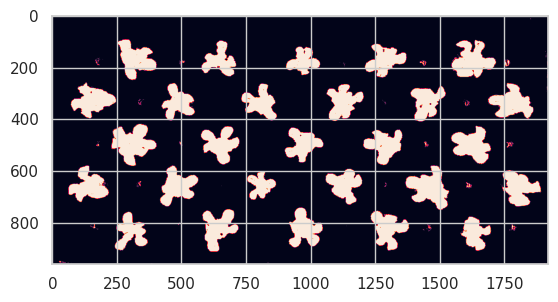

In [ ]:
print(np.unique(result))
plt.imshow(result)

## Original MASK
Transform pixel intensities into a binary image with values of either 0 or 1 to be able to compare between mask and prediction


<function unique at 0x7ac4c09a7370>


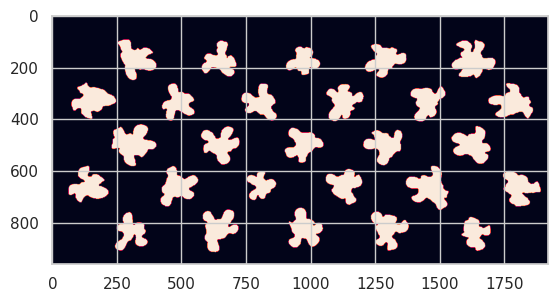

In [ ]:
original_mask = cv2.imread(img_mask,0) # read as grayscale
original_mask = cv2.normalize(original_mask, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
print(np.unique)
plt.imshow(original_mask)

# Model Metrics on validation images. Metrics we will include:
- Jaccard index (mIoU)
- F1 index

In [ ]:
intersection = np.logical_and(original_mask, result)
union = np.logical_or(original_mask, result)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU score is: ", iou_score)

IoU score is:  0.9384554809066585


In [17]:
from sklearn.metrics import precision_score, recall_score,f1_score,jaccard_score

def seg_metrics(true_mask,predicted_mask):
    # Flatten the masks if they are not already flattened
    y_true = true_mask.flatten()
    y_pred = predicted_mask.flatten()

    precision = precision_score(y_true,y_pred)
    recall = recall_score(y_true,y_pred)
    f1 = f1_score(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred) # IOU

    return precision,recall,f1,jaccard

In [18]:
bin_precision, bin_recall, bin_f1, bin_jaccard = seg_metrics(y_test,prediction_test)
metrics_dict = {'Precision': bin_precision, 'Recall':bin_recall, 'F1_Score': bin_f1, 'Jaccard (IOU)': bin_jaccard}
metrics_df = pd.DataFrame([metrics_dict])
metrics_df

,Precision,Recall,F1_Score,Jaccard (IOU)
0,0.981045,0.984895,0.982967,0.966504


# Model hyperparameters definition

We start by creating a list for the values we want to test for each  we want to evaluate. Selection of the values to try depends on the size of our data.

In [ ]:
# Number of trees in random forest
n_estimators = [25,50,75]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

Next, we create a dictionary using all the list we create on the step before. Here **hyperparameters names** should match the names of the hyperparameters in the GridSearch CV.

In [ ]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [25, 50, 75], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [ ]:
rf_model = RandomForestClassifier()

# Using **GRIDSEARCH CV** to tunne hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV
rf_Grid = GridSearchCV(estimator = rf_model, param_grid = param_grid, cv = 4, verbose = 2, n_jobs =4)

In [ ]:
rf_Grid.fit(x_train, y_train)

Fitting 4 folds for each of 96 candidates, totalling 384 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


KeyboardInterrupt: ignored